In [2]:
import gym
import gym_ple
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
import time 
env = gym.make('FlappyBird-v0')

In [26]:
# function used to get frames for each step of action
def get_frames(env, agent, steps):
    observation = env.reset()
    frames = []
    score = 0
    # render into buffer
    frames.append(env.render(mode = 'rgb_array'))
    for step in range(steps):
        state = get_state(env)
        action = agent.choose_action(state, enable_greedy = False)
        observation, reward, done, info = env.step(action)
        # render into buffer
        frames.append(env.render(mode = 'rgb_array'))
        if reward == 1:
            score += 1
        if done:
            print('Game Over!')
            break        
    return score, frames


# function used to save the frames as animation and gif for displaying
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    gif = display_animation(anim, default_mode='loop')
    
    return anim, gif

In [4]:
# function used to get state not including next next pipe state
def get_state(env):
    info =  vars(env)['env'].game_state.game.getGameState()
    # height between the bird's y and next pipe's top y
    dist_to_pipe_bottom = info['player_y'] - info['next_pipe_top_y']
    # distance between the bird's x and next pipe's x
    dist_to_pipe_horz = info['next_pipe_dist_to_player']
    # velocity
    velocity = info['player_vel']
    
    # make a height category of height between the bird's y and next pipe's bottom y
    if dist_to_pipe_bottom < 8:     # very close or less than 0
        height_category = 0
    elif dist_to_pipe_bottom < 20:  # close
        height_category = 1
    elif dist_to_pipe_bottom < 50:  # not close
        height_category = 2
    elif dist_to_pipe_bottom < 125: # mid
        height_category = 3
    elif dist_to_pipe_bottom < 250: # far
        height_category = 4
    else:
        height_category = 5

    # make a distance category 
    if dist_to_pipe_horz < 8:     # very close
        dist_category = 0
    elif dist_to_pipe_horz < 20:  # close
        dist_category = 1
    elif dist_to_pipe_horz < 50:  # not close
        dist_category = 2
    elif dist_to_pipe_horz < 125: # mid 
        dist_category = 3
    elif dist_to_pipe_horz < 250: # far
        dist_category = 4
    else:
        dist_category = 5
        
    state = (height_category, dist_category, velocity)
    
    return state

In [5]:
class Q_Agent:
    def __init__(self, fname = None, alpha = 0.7, greedy = 0.8):
        self.alpha = alpha
        self.greedy = greedy
        self.action_space = [0,1] # 0 for jump, 1 for stay
        self.r = {0: 1, 1: 1, -5: -1000, -4: -1000}
        self.score = {0: 0, 1: 1, -5: 0, -4: 1}
        if fname is None:
            self.q = {}
        else:
            # load q table from files
            self.read_q(fname)
    
    
    # make the epsilon rate decreased by time
    def update_para(self, t):
        self.greedy = self.greedy/t
  

    # get q value, if the key is not exist (since initial the q table as empty dictionary), initial its value as 0
    def getQ(self, state, action):
        if self.q.get((state, action)) is None:
            self.q[(state, action)] = 0
            
        return self.q.get((state, action))
    
    
    def choose_action(self, state, enable_greedy = True):
        # enable_greedy = False is used for test only, never make the non-greedy move
        # default as True, have a probability to make the non-greedy move
        if enable_greedy:
            if np.random.rand(1) < self.greedy:
                # choose not greedy action 
                chosen_action = np.random.choice(self.action_space)
            else:
                # choose greedy action according to Q table
                # get the maximum Q value of the current state
                max_q = np.array([self.getQ(state, p_action) for p_action in self.action_space]).max()
                # create= a current dictionary which is a part of Q table to avoid of different state, 
                # but same q value
                current_key = [(state, p_action) for p_action in self.action_space]
                new_d = {key:self.q[key] for key in current_key}
                # choose the action, if there are several actions, choose randomly
                choices = [key for key in new_d.keys() if new_d[key]==max_q]  
                chosen_action = choices[np.random.choice(len(choices))][1]
        else:
            # choose greedy action according to Q table
            # get the maximum Q value of the current state
            max_q = np.array([self.getQ(state, p_action) for p_action in self.action_space]).max()
            # create= a current dictionary which is a part of Q table to avoid of different state, 
            # but same q value
            current_key = [(state, p_action) for p_action in self.action_space]
            new_d = {key:self.q[key] for key in current_key}
            # choose the action, if there are several actions, choose randomly
            choices = [key for key in new_d.keys() if new_d[key]==max_q]  
            chosen_action = choices[np.random.choice(len(choices))][1]
            
        return chosen_action
    
    
    def Q_learn(self, old_state, new_state, action, reward):
        max_value = np.array([self.getQ(new_state, p_action) for p_action in self.action_space]).max()
        self.q[(old_state,action)] = (1-self.alpha)*self.getQ(old_state,action)+self.alpha*(reward+max_value)
        
        
    # save q table in a file, so we can load it back in later
    def save_q(self, fname):
        f = open(fname, "w")
        f.write(str(self.q))
        f.close()
        
        
    # load saved q table
    def read_q(self, fname):
        with open(fname, 'r') as f:
            data_string = f.read()
            data_dict = ast.literal_eval(data_string)
            self.q = data_dict

In [6]:
def simulate_Q(env, agent, episodes):
    record = np.zeros(episodes)
    for episode in range(episodes):
        total_score = 0
        _ = env.reset()
        # make the epsilon rate decreased by time
        agent.update_para(episode+1)
        while vars(env)['env'].game_state.game_over() == False:
            old_state = get_state(env)
            chosen_action = agent.choose_action(old_state)
            _,reward,_,_ = env.step(chosen_action)
            total_score += agent.score[reward]
            # redefine reward from the gym package
            real_reward = agent.r[reward]
            new_state = get_state(env)
            agent.Q_learn(old_state,new_state,chosen_action,real_reward)
            
        record[episode] = total_score
        percent = 100*(episode+1)/episodes
        if percent%10 == 0:
            print('Train',percent,'% percentage')
            
    return record

In [7]:
episodes = 2000
agent = Q_Agent()
score_record = simulate_Q(env, agent, episodes)

Train 10.0 % percentage
Train 20.0 % percentage
Train 30.0 % percentage
Train 40.0 % percentage
Train 50.0 % percentage
Train 60.0 % percentage
Train 70.0 % percentage
Train 80.0 % percentage
Train 90.0 % percentage
Train 100.0 % percentage


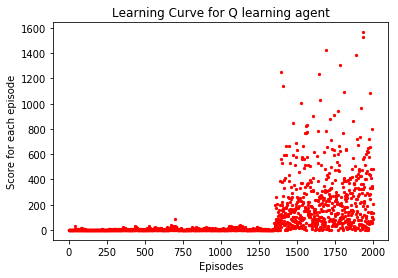

In [8]:
plt.scatter(np.arange(episodes), score_record, c='r', s=5)
plt.xlabel('Episodes')
plt.ylabel('Score for each episode')
plt.title('Learning Curve for Q learning agent')
plt.savefig('output_fig.png')

In [ ]:
# test demo
agent = Q_Agent('qtable.txt')
score, frames = get_frames(env, agent, 9999999)
print('The total score is', score)
anim, gif = display_frames_as_gif(frames)
display(gif)

In [14]:
#anim.save('test.avi')

In [32]:
#agent.save_q('qtable.txt')

In [ ]:
#agent = Q_Agent('qtable.txt')